## Imports

In [87]:
import os
import json
import pysam
import gcsfs
import tarfile
import upsetplot
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

from google.cloud import storage
from collections import Counter
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from tabulate import tabulate
from IPython.core.display import display, HTML
from pandas.api.types import CategoricalDtype

/tmp/ipykernel_104/1127186408.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [88]:
# ! pip install upsetplot

## Constants

### User Inputs

In [89]:
use_cache = True

include_vapor = False

distinct_vapor_no_call = True

subset = "stratified_pb_vFinal"
# subset = "stratified_manta_pb_vFinal"

min_size_cache = None
max_size_cache = None
valid_types_cache = ["DEL", "DUP", "INS", "INV", "BND"]

min_size_filter = None
max_size_filter = 5000
valid_types_filter = ["DEL", "DUP", "INS", "INV"]
    
info_fields = ["SVTYPE", "AF", "STRAT"]

format_fields = ["GT"]

mode = "strict"

if "pb" in subset:
    lr_callers = ["PBSV", "SNIFFLES"]
    vcf_shards = {
        "PBSV": "shard-0",
        "SNIFFLES": "shard-1",
    }
    samples_filter = ["RGP_1446_1", "RGP_1446_3", "RGP_1883_3", "RGP_2166_1", "RGP_2166_3"]
    inv_samples = [
        "RGP_1012_1", "RGP_1446_2", "RGP_1547_3", "RGP_1641_3",  "RGP_1750_3", "RGP_1777_1",  "RGP_1780_2",  
        "RGP_1836_3", "RGP_1890_3", "RGP_2021_3",  "RGP_2120_1",  "RGP_2122_3",  "RGP_2158_1",  "RGP_2159_3", 
        "RGP_2174_2", "RGP_2211_2",  "RGP_2282_3", "RGP_2353_3",  "RGP_469_2",  "RGP_654_3",  "RGP_955_3"
    ]
elif "ont" in subset:
    lr_callers = ["SNIFFLES", "HAPDIFF"]
    vcf_shards = {
        "SNIFFLES": "shard-0",
        "HAPDIFF": "shard-1"
    }
    samples_filter = ["RGP_1219_1", "RGP_1608_3", "RGP_1219_2", "RGP_25_1"]
    inv_samples = [
        "RGP_1081_1", "RGP_12_1", "RGP_1608_2", "RGP_2040_1", "RGP_25_2",
        "RGP_607_2", "RGP_686_2", "RGP_731_1", "RGP_858_2"
    ]

### Additional

In [90]:
in_dir = f"/home/jupyter/Files/inputs/{subset}"
out_dir = f"/home/jupyter/Files/outputs/{subset}/{mode}"
os.makedirs(out_dir, exist_ok=True)

recalibrator_txt = os.path.join(in_dir, "gq_recalibrator_labels.txt")
recalibrator_json = os.path.join(in_dir, "gq_recalibrator_labels.vapor.json")
input_file_path = os.path.join(in_dir, f"{mode}.txt")
sites_vcf_path = os.path.join(in_dir, "concat_training_sample_vcfs.vcf.gz")
filters_json = os.path.join(in_dir, "filters.json")

tsv_files = {
    shard: os.path.join(out_dir, f"{caller}.tsv") for caller, shard in vcf_shards.items()
}

cached_df_path = os.path.join(out_dir, "cached_df.tsv")

palette = sns.set_palette("muted")

fm.fontManager.addfont("/home/jupyter/Files/inputs/Archive/arial.ttf")
fm.fontManager.addfont("/home/jupyter/Files/inputs/Archive/arialbd.ttf")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

support_color_map = {
    "Supported": "#a9deb5",
    "Unsupported": "#f7b2b2", 
    "Vapor No Call": "#faf2c0"
}

## Helper Functions

In [91]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [92]:
def clean_directory(out_dir_):
    for root, dirs, files in os.walk(out_dir_):
        for name in files:
            file_path = os.path.join(root, name)
            if file_path not in tsv_files.values():
                os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            if not os.listdir(dir_path):
                os.rmdir(dir_path)

In [93]:
def compute_summary(df, filter_col, filter_val, n_samples, support_val=1, pre_filter=False, check_binary=False, filter_col2=None, filter_val2=None):
    df_filtered = df[df[filter_col] == filter_val] if pre_filter else df
    if filter_col2 is not None and filter_val2 is not None:
        df_filtered = df_filtered[df_filtered[filter_col2] == filter_val2]
    
    calls_count = df_filtered.shape[0]
    calls_supported_count = df_filtered[(df_filtered["N_LR_SUPPORT"] >= support_val) & (df_filtered[filter_col] == 1)].shape[0] if check_binary else df_filtered[df_filtered["N_LR_SUPPORT"] >= support_val].shape[0]
    
    calls_per_genome = round(calls_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_per_genome = round(calls_supported_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_proportion = f"{round((calls_supported_count / calls_count) * 100, 2)}%" if calls_count > 0 else 0
    
    filter_val = f"{filter_val} + {filter_val2}" if filter_col2 is not None and filter_val2 is not None else filter_val
    return [ filter_val, calls_per_genome, calls_supported_per_genome, calls_supported_proportion ]

In [94]:
def plot_hist(data, x, distinct_vapor_no_call=False,
                xlabel=None,
                ylabel=None,
                color_map=None,
                legend_title=None,
                legend_labels=None,
                legend_loc=None,
                legend_bbox_to_anchor=None,
                legend_frameon=True,
                save_path=None,
                **kwargs):
    xlabel_fontsize = kwargs.pop('xlabel_fontsize', 12)
    ylabel_fontsize = kwargs.pop('ylabel_fontsize', 12)
    tick_fontsize = kwargs.pop('tick_fontsize', 11)
    legend_title_fontsize = kwargs.pop('legend_title_fontsize', 11)
    legend_fontsize = kwargs.pop('legend_fontsize', 10)
    
    height = kwargs.pop('height', 5)
    aspect = kwargs.pop('aspect', 1.7)

    df_plot = data.copy()
    hue_col = kwargs.get("hue")

    if distinct_vapor_no_call and hue_col == "SUPPORT":
        hue_col = "SUPPORT_DISTINCT"
        df_plot[hue_col] = df_plot["SUPPORT"].copy()
        if not pd.api.types.is_categorical_dtype(df_plot[hue_col]):
            df_plot[hue_col] = pd.Categorical(df_plot[hue_col], categories=list(df_plot["SUPPORT"].unique()) + ["Vapor No Call"])
        else:
            df_plot[hue_col] = df_plot[hue_col].cat.add_categories(["Vapor No Call"])
        df_plot.loc[df_plot["STATUS_VAPOR"] == -1, hue_col] = "Vapor No Call"
        kwargs["hue"] = hue_col

    g = sns.displot(
        data=df_plot, x=x,
        palette=color_map,
        multiple="stack",
        edgecolor="0",
        linewidth=1,
        height=height,
        aspect=aspect,
        **kwargs
    )

    g.ax.set_xlabel(xlabel if xlabel is not None else x, fontsize=xlabel_fontsize, fontweight='bold')
    g.ax.set_ylabel(ylabel if ylabel is not None else g.ax.get_ylabel(), fontsize=ylabel_fontsize, fontweight='bold')
    g.ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    if str(df_plot[x].dtype) == "object" or isinstance(df_plot[x].dtype, pd.CategoricalDtype):
        rotation = 90
        for i, ax in enumerate(g.fig.axes):
            ticks_loc = ax.get_xticks()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

    if g.legend:
        if legend_title is not None:
            g.legend.set_title(legend_title)
        if legend_labels is not None and len(g.legend.texts) == len(legend_labels):
            for t, l in zip(g.legend.texts, legend_labels):
                t.set_text(l)
        
        g.legend.set_frame_on(legend_frameon)

        if legend_loc:
            sns.move_legend(g, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor)
        
        plt.setp(g.legend.get_texts(), fontsize=legend_fontsize)
        plt.setp(g.legend.get_title(), fontsize=legend_title_fontsize)

    if save_path:
        g.savefig(save_path, transparent=True, dpi=300, bbox_inches='tight')
    
    plt.show()

In [95]:
def plot_averaged_hist(data, group_col, n_samples, support_col="SUPPORT", 
                         distinct_vapor_no_call=False,
                         xtick_rotation=90,
                         xlabel=None, 
                         xticklabels=None,
                         legend_title=None,
                         legend_labels=None,
                         color_map=None,
                         legend_loc='best',
                         legend_bbox_to_anchor=None,
                         legend_frameon=True,
                         save_path=None,
                         group_order=None,
                         **kwargs):
    xlabel_fontsize = kwargs.pop('xlabel_fontsize', 12)
    ylabel_fontsize = kwargs.pop('ylabel_fontsize', 12)
    tick_fontsize = kwargs.pop('tick_fontsize', 11)
    total_fontsize = kwargs.pop('total_fontsize', 12)
    percent_fontsize = kwargs.pop('percent_fontsize', 12)
    legend_title_fontsize = kwargs.pop('legend_title_fontsize', 11)
    legend_fontsize = kwargs.pop('legend_fontsize', 10)
    
    df_plot = data.copy()

    if group_order:
        cat_type = CategoricalDtype(categories=group_order, ordered=True)
        df_plot[group_col] = df_plot[group_col].astype(cat_type)

    if pd.api.types.is_categorical_dtype(df_plot[group_col]):
        df_plot[group_col] = df_plot[group_col].cat.remove_unused_categories()
    plot_support_col = support_col

    if distinct_vapor_no_call and support_col == "SUPPORT":
        plot_support_col = "SUPPORT_DISTINCT"
        df_plot[plot_support_col] = df_plot["SUPPORT"].copy()
        if not pd.api.types.is_categorical_dtype(df_plot[plot_support_col]):
            df_plot[plot_support_col] = pd.Categorical(
                df_plot[plot_support_col],
                categories=list(df_plot["SUPPORT"].unique()) + ["Vapor No Call"]
            )
        else:
            df_plot[plot_support_col] = df_plot[plot_support_col].cat.add_categories(["Vapor No Call"])
        df_plot.loc[df_plot["STATUS_VAPOR"] == -1, plot_support_col] = "Vapor No Call"
    
    grouped = df_plot.groupby([group_col, plot_support_col], observed=False).size().unstack(fill_value=0)
    grouped = grouped / n_samples

    ax = grouped.plot(kind="bar", stacked=True, color=color_map, legend=False, edgecolor="0", linewidth=0.3, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Calls per Genome", fontsize=ylabel_fontsize, fontweight='bold')
    
    ax.set_xlabel(xlabel if xlabel is not None else group_col, fontsize=xlabel_fontsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    if xticklabels:
        ax.set_xticklabels(xticklabels, rotation=xtick_rotation)
    
    patches_by_bar = {}
    totals_per_group = grouped.sum(axis=1)
    for p in ax.patches:
        group_idx = int(np.round(p.get_x() + p.get_width() / 2))
        if group_idx not in patches_by_bar:
            patches_by_bar[group_idx] = []
        patches_by_bar[group_idx].append(p)

    for group_idx, patch_list in patches_by_bar.items():
        internal_patches = []
        external_patches = []
        placement_threshold = ax.get_ylim()[1] * 0.04

        for p in patch_list:
            if p.get_height() < placement_threshold:
                external_patches.append(p)
            else:
                internal_patches.append(p)

        for p in internal_patches:
            height = p.get_height()
            total = totals_per_group.iloc[group_idx]
            if height > 0 and total > 0:
                percent = height / total * 100
                if percent < 0.1: continue
                label = f"{percent:.2f}%"
                rgb = p.get_facecolor()[:3]
                luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
                text_color = "white" if luminance < 0.4 else "black"
                ax.text(p.get_x() + p.get_width() / 2, p.get_y() + height / 2, label, 
                        ha="center", va="center", color=text_color, fontsize=percent_fontsize)

        if len(external_patches) > 0:
            if len(external_patches) > 1:
                target_patch = max(external_patches, key=lambda p: p.get_height())
                patches_to_label = [target_patch]
            else:
                patches_to_label = external_patches
            
            for p in patches_to_label:
                height = p.get_height()
                total = totals_per_group.iloc[group_idx]
                if height > 0 and total > 0:
                    percent = height / total * 100
                    if percent < 0.1: continue
                    label = f"{percent:.2f}%"
                    ax.text(p.get_x() + p.get_width() * 1.05, p.get_y() + height / 2, label, 
                            ha="left", va="center", color="black", fontsize=percent_fontsize)

    totals = grouped.sum(axis=1)
    ylim = ax.get_ylim()
    offset = (ylim[1] - ylim[0]) * 0.01
    xticks = ax.get_xticks()
    for i, total in enumerate(totals):
        ax.text(xticks[i], total + offset, f"{total:.2f}", ha="center", va="bottom", fontsize=total_fontsize)
    
    plt.tight_layout()
    
    handles, labels = ax.get_legend_handles_labels()
    if legend_labels:
        labels = legend_labels
    
    ax.legend(
        handles,
        labels,
        title=legend_title,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox_to_anchor,
        fontsize=legend_fontsize,
        title_fontsize=legend_title_fontsize,
        frameon=legend_frameon
    )
    
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches='tight')
    
    plt.show()

In [96]:
def plot_incremental_hist(data, include_vapor=False, distinct_vapor_no_call=False, **kwargs):
    data = data.copy()
    original_vals = sorted(data["N_LR_SUPPORT"].unique())
    unique_vals = original_vals if include_vapor and distinct_vapor_no_call else [v for v in original_vals if v > 0]
    
    if include_vapor:
        data.loc[data["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
    incremental_counts = {}
    
    for val in unique_vals:
        if include_vapor:
            if val == -1:
                subset = data[data["STATUS_VAPOR"] == -1]
            else:
                subset = data[(data["STATUS_VAPOR"] != -1) & (data["N_LR_SUPPORT"] >= val)]
        else:
            subset = data[data["N_LR_SUPPORT"] >= val]
        incremental_counts[val] = subset.shape[0] / len(data)
    inc_df = pd.DataFrame({"Threshold": list(incremental_counts.keys()), "Proportion": list(incremental_counts.values())})
    
    if include_vapor:
        inc_df["Threshold"] = inc_df["Threshold"].replace({-1: "Vapor No Call"})
    ax = sns.barplot(x="Threshold", y="Proportion", data=inc_df, **kwargs)
    plt.xlabel("Number of Supporting Callers")
    plt.ylabel("Proportion of Calls")
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f"{height*100:.2f}%", ha="center", va="bottom")
    plt.show()

In [97]:
def plot_upset_lr(input_df, min_subset_size=None, by_svtype=True, ylim=None):
    upset_df = input_df.copy()
    if "VAPOR" in lr_callers and include_vapor:
        upset_df["vapor"] = upset_df["STATUS_VAPOR"]
    
    for c in lr_callers:
        if c != "VAPOR":
            upset_df[c.lower()] = upset_df["STATUS_" + c]
    
    active_callers = []
    for c in lr_callers:
        if c == "VAPOR" and include_vapor:
            active_callers.append("vapor")
        elif c != "VAPOR":
            active_callers.append(c.lower())
    
    upset_df = upset_df.set_index(upset_df[active_callers[0]] == 1)
    for sc in active_callers[1:]:
        upset_df = upset_df.set_index(upset_df[sc] == 1, append=True)
    if by_svtype:
        upset = upsetplot.UpSet(
            upset_df, subset_size="count", min_subset_size=min_subset_size, intersection_plot_elements=0
        )
        upset.add_stacked_bars(by="SVTYPE", colors=cm.Set2, title="Intersection Size", elements=10)
    else:
        upset = upsetplot.UpSet(upset_df, subset_size="count", min_subset_size=min_subset_size)
    
    upset.add_catplot(value="log_SVLEN", kind="violin", color="gray")
    if "SL" in input_df.columns:
        upset.add_catplot(value="SL", kind="box", color="gray", fliersize=0)
    
    fig = plt.figure(dpi=100)
    upset_axes = upset.plot(fig=fig)
    intersect_key = 'extra0' if by_svtype else 'intersections'
    if ylim is not None:
        upset_axes[intersect_key].set_ylim(ylim)
    plt.show()
    plt.savefig('')

In [98]:
def should_remove(row):
    sample, vid = row["SAMPLE"], row["VID"]
    return sample in sample_to_vids and vid in sample_to_vids[sample]

## Process

### Verification

In [99]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [100]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [101]:
# Load per-caller VCFs

if not use_cache:
    gcs_client = storage.Client()
    
    for shard_path in tsv_files.values():
        os.makedirs(os.path.dirname(shard_path), exist_ok=True)
        with open(shard_path, "w") as f:
            f.write(
                "\t".join(
                    ["VID", "SAMPLE", "CHROM", "POS", "SVLEN", "STATUS", "DRAGEN"]
                    + format_fields
                    + info_fields
                )
                + "\n"
            )

    if os.path.exists(input_file_path):
        with open(input_file_path, "r") as f:
            tarball_paths = [line.strip() for line in f.readlines()]
    else:
        tarball_paths = []

    shard_to_caller = {v: k for k, v in vcf_shards.items()}

    for tarball_path in tarball_paths:
        tarball_filename = os.path.basename(tarball_path)
        local_tarball_path = os.path.join(out_dir, tarball_filename)
        bucket_name, object_name = tarball_path[5:].split("/", 1)
        bucket = gcs_client.bucket(bucket_name)
        blob = bucket.blob(object_name)
        blob.download_to_filename(local_tarball_path)
        with tarfile.open(local_tarball_path, "r:gz") as tar:
            tar.extractall(out_dir)

        full_paths = []
        for root, dirs, files in os.walk(out_dir):
            if not dirs:
                for file in files:
                    if file.endswith(".vcf.gz"):
                        full_paths.append(os.path.join(root, file))

        candidate = False
        for path_ in full_paths:
            for kc in vcf_shards.keys():
                if kc.lower() in path_.lower():
                    candidate = True
                    break

        if not candidate:
            clean_directory(out_dir)
            continue

        for file_path in full_paths:
            shard = None
            for d_ in file_path.split(os.sep):
                if "shard" in d_.lower():
                    shard = d_
            caller = shard_to_caller.get(shard)
            if not caller:
                continue
            tsv_out = tsv_files[shard]
            with pysam.VariantFile(file_path) as vcf, open(tsv_out, "a") as tsv_handle:
                for r in vcf:
                    svtype = r.info.get("SVTYPE", None)
                    svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
                    
                    if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
                    
                    if max_size_cache is not None:
                        if svlen > max_size_cache:
                            continue
                            
                    if min_size_cache is not None:
                        if svlen < min_size_cache:
                            continue

                    row_data = []
                    for s in r.samples:
                        if _is_non_ref(r.samples[s]["GT"]):
                            base = [
                                r.id,
                                s,
                                r.chrom,
                                r.pos,
                                svlen,
                                1 if r.info.get("STATUS", "") == "TP" else 0,
                                1 if any("dragen" in alg for alg in r.info.get("ALGORITHMS", [])) 
                                    or 'dragen' in r.info.get('ALGORITHMS', '') 
                                    or any("manta" in alg for alg in r.info.get("ALGORITHMS", []))
                                    or 'manta' in r.info.get('ALGORITHMS', '')
                                else 0
                            ]
                            
                            fmts = [r.samples[s].get(k, None) for k in format_fields if k in format_fields]
                            
                            infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
                            
                            row_data.append(base + fmts + infs)
                    
                    if row_data:
                        for rd_ in row_data:
                            tsv_handle.write("\t".join(str(x) for x in rd_) + "\n")

        clean_directory(out_dir)

In [102]:
# Load per-sample recalibrator JSONs

if not use_cache and include_vapor:
    with open(recalibrator_txt, "r") as f:
        with open(recalibrator_json, "w") as out_f:
            out_f.write("{")
            first_entry = True

            for line in f:            
                json_path = line.strip()
                process = subprocess.Popen(
                    ["gsutil", "cat", json_path],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    text=True
                )
                stdout, stderr = process.communicate()

                data = json.loads(stdout)
                sample_id, variant_data = next(iter(data.items()))

                if not first_entry:
                    out_f.write(",")
                out_f.write(f'"{sample_id}":')
                json.dump(variant_data, out_f)

                first_entry = False

            out_f.write("}")

### Dataframe Generation

In [103]:
# Load Vapor labels into memory

if not use_cache:
    if include_vapor:
        with open(recalibrator_json, "r") as f:
            tmp = json.load(f)
        vapor_labels = {}
        for s in tmp:
            vapor_labels[s] = {
                "good_variant_ids": set(tmp[s]["good_variant_ids"]),
                "bad_variant_ids": set(tmp[s]["bad_variant_ids"])
            }
    else:
        vapor_labels = {}

In [104]:
# Join files

if not use_cache:
    # Load df_ref for a single reference caller
    ref_caller = lr_callers[0]
    ref_shard = vcf_shards[ref_caller]
    ref_tsv_path = tsv_files[ref_shard]
    df = pd.read_csv(ref_tsv_path, sep="\t")
    
    # Create ID
    df["ID"] = df["VID"].astype(str) + "_" + df["SAMPLE"].astype(str)

    # Bring in STATUS column from other callers
    for caller in lr_callers[1:]:
        shard = vcf_shards[caller]
        tsv_path = tsv_files[shard]
        df_other = pd.read_csv(tsv_path, sep="\t")

        # Build matching ID = VID + "_" + SAMPLE
        df_other["ID"] = df_other["VID"].astype(str) + "_" + df_other["SAMPLE"].astype(str)

        # Rename STATUS -> STATUS_{caller}, keep only that col + ID
        df_other.rename(columns={"STATUS": f"STATUS_{caller}"}, inplace=True)
        df_other = df_other[["ID", f"STATUS_{caller}"]]

        # Join on ID
        df = (
            df.set_index("ID")
            .join(
                df_other.set_index("ID"),
            )
            .reset_index()
        )
        
    # Set final index
    df = df.set_index("ID")
    
    # Rename STATUS column
    df = df.rename(columns={"STATUS": f"STATUS_{ref_caller}"})

### Dataframe Processing

In [105]:
# Formatting

if not use_cache:
    # Set STATUS_VAPOR
    if include_vapor:
        df["STATUS_VAPOR"] = df.apply(
            lambda row: (
                1 if row["SAMPLE"] in vapor_labels and row["VID"] in vapor_labels[row["SAMPLE"]]["good_variant_ids"]
                else (0 if row["SAMPLE"] in vapor_labels and row["VID"] in vapor_labels[row["SAMPLE"]]["bad_variant_ids"]
                      else -1)
            ), axis=1
        )
        lr_callers.append("VAPOR")

    # Set AF
    if "AF" in df.columns:
        df["AF"] = df["AF"].astype(str).str.replace(r"[(),]", "", regex=True).astype(float)

    # Set column types
    df = df.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "POS" in df.columns:
        df["POS"] = df["POS"].astype(int)
    if "GQ" in df.columns:
        df["GQ"] = df["GQ"].astype(float)
    if "SL" in df.columns:
        df["SL"] = df["SL"].astype(float)
        
    # Process categorical
    df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

    # Process STRAT
    if "STRAT" in df.columns:
        def assign_strat(s):
            if pd.isna(s):
                return "Unique"
            elif "SR_" in s:
                return "SR"
            elif "SD_" in s:
                return "SD"
            elif "RM_" in s:
                return "RM"
            else:
                return "Unique"

        df["STRAT"] = df["STRAT"].apply(assign_strat)

        df['STRAT'] = pd.Categorical(df['STRAT'])

In [106]:
# Enhancement

if not use_cache:
    # Set log_SVLEN
    df["log_SVLEN"] = np.log10(df["SVLEN"].where(df["SVLEN"] > 0, np.nan))
    
    # Set SVCLASS
    df["SVCLASS"] = df["SVTYPE"].copy()
    df.loc[df["SVTYPE"] == "DUP", "SVCLASS"] = "INS"

    # Set SIZE
    df["SIZE"] = df["SVLEN"]
    df.loc[df["SVTYPE"] == "DEL", "SIZE"] = -df.loc[df["SVTYPE"] == "DEL", "SIZE"]

    # Set LRWGS
    df["LRWGS"] = 0
    for c in lr_callers:
        if c == "VAPOR" and not include_vapor:
            continue
        df.loc[df[f"STATUS_{c}"] == 1, "LRWGS"] = 1

    # Set SRWGS
    df['SRWGS'] = 0
    df.loc[(df['DRAGEN'] == 1), 'SRWGS'] = 1

    # Set SUPPORT
    df["SUPPORT"] = "SR"
    df.loc[(df["SRWGS"] == 1) & (df["LRWGS"] == 1), "SUPPORT"] = "SR+LR"
    df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

    # Set N_LR_SUPPORT
    df["N_LR_SUPPORT"] = 0
    for c in lr_callers:
        df["N_LR_SUPPORT"] += df[f"STATUS_{c}"]

In [107]:
if not use_cache:
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [108]:
df = pd.read_csv(cached_df_path, sep="\t")

if use_cache and include_vapor and "VAPOR" not in lr_callers:
    lr_callers.append("VAPOR")

df.head()

,VID,SAMPLE,CHROM,POS,SVLEN,STATUS_PBSV,DRAGEN,GT,SVTYPE,AF,STRAT,STATUS_SNIFFLES,STATUS_VAPOR,log_SVLEN,SVCLASS,SIZE,LRWGS,SRWGS,SUPPORT,N_LR_SUPPORT
0,MantaDEL_23984_0_1_0_0_0,RGP_1012_1,chr1,934027,918,1,1,"(0, 1)",DEL,0.5,SR,1,1,2.962843,DEL,-918,1,1,SR+LR,3
1,MantaDUP_TANDEM_23983_0_1_0_0_0,RGP_1012_1,chr1,998743,52,1,1,"(0, 1)",INS,0.5,SR,1,1,1.716003,INS,52,1,1,SR+LR,3
2,MantaINS_23983_0_0_0_0_0,RGP_1012_1,chr1,998763,58,1,1,"(1, 1)",INS,1.0,SR,1,1,1.763428,INS,58,1,1,SR+LR,3
3,MantaINS_23988_0_0_0_0_0,RGP_1012_1,chr1,1068824,78,1,1,"(1, 1)",INS,1.0,SR,1,1,1.892095,INS,78,1,1,SR+LR,3
4,MantaDEL_24025_0_0_0_0_0,RGP_1012_1,chr1,1207339,422,1,1,"(0, 1)",DEL,0.5,Unique,1,1,2.625312,DEL,-422,1,1,SR+LR,3


In [109]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

if "STRAT" in df.columns:
    df['STRAT'] = pd.Categorical(df['STRAT'])

df["SUPPORT"] = df["SUPPORT"].replace({"SR": "Unsupported", "SR+LR": "Supported"})
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

In [110]:
# Filtering

# Undo Vapor negation
if include_vapor:
    df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
else:
    if "STATUS_VAPOR" in df.columns:
        df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]

# Set Vapor no calls to false positives
# if include_vapor:
#     df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
#     df.loc[df["STATUS_VAPOR"] == -1, "STATUS_VAPOR"] = 0
# else:
#     if "STATUS_VAPOR" in df.columns:
#         df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]

# Remove Vapor no calls
# if include_vapor:
#     bef = len(df)
#     df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
#     df = df[df["STATUS_VAPOR"] != -1]
#     print(f"[Vapor No Calls] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
# else:
#     if "STATUS_VAPOR" in df.columns:
#         df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]

# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
if valid_types_filter is not None:
    bef = len(df)
    df = df[df["SVTYPE"].isin(valid_types_filter)]
    print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Remove invalid SAMPLE
if samples_filter is not None:
    bef = len(df)
    df = df[~df["SAMPLE"].isin(samples_filter)]
    print(f"[Invalid SAMPLE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n") 

# Remove non-pass FILTER
# with open(filters_json, "r") as f:
#     filters_data = json.load(f)
#     sample_to_vids = {}
#     for sample, filt_dict in filters_data.items():
#         vid_filters = {}
#         for filt, vid_list in filt_dict.items():
#             for vid in vid_list:
#                 vid_filters.setdefault(vid, set()).add(filt)
#         sample_to_vids[sample] = vid_filters
# df["FILTER"] = df.apply(
#     lambda row: ",".join(sorted(sample_to_vids[row["SAMPLE"]][row["VID"]]))
#                 if (row["SAMPLE"] in sample_to_vids and row["VID"] in sample_to_vids[row["SAMPLE"]])
#                 else "",
#     axis=1
# )
# 
# with open(filters_json, "r") as f:
#     filters_data = json.load(f)
#     sample_to_vids = {
#         sample: { vid for filter_list in filters_data[sample].values() for vid in filter_list }
#         for sample in filters_data
#     }
# bef = len(df)
# df = df[~df.apply(should_remove, axis=1)]
# print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n") 

df.head()

[SVLEN > Max Size] Dropped 60908 records (3.75%), now left with 1563944.

[Invalid SVTYPE] Dropped 0 records (0.0%), now left with 1563944.

[Invalid SAMPLE] Dropped 0 records (0.0%), now left with 1563944.



,VID,SAMPLE,CHROM,POS,SVLEN,STATUS_PBSV,DRAGEN,GT,SVTYPE,AF,STRAT,STATUS_SNIFFLES,STATUS_VAPOR,log_SVLEN,SVCLASS,SIZE,LRWGS,SRWGS,SUPPORT,N_LR_SUPPORT
0,MantaDEL_23984_0_1_0_0_0,RGP_1012_1,chr1,934027,918,1,1,"(0, 1)",DEL,0.5,SR,1,1,2.962843,DEL,-918,1,1,Supported,2
1,MantaDUP_TANDEM_23983_0_1_0_0_0,RGP_1012_1,chr1,998743,52,1,1,"(0, 1)",INS,0.5,SR,1,1,1.716003,INS,52,1,1,Supported,2
2,MantaINS_23983_0_0_0_0_0,RGP_1012_1,chr1,998763,58,1,1,"(1, 1)",INS,1.0,SR,1,1,1.763428,INS,58,1,1,Supported,2
3,MantaINS_23988_0_0_0_0_0,RGP_1012_1,chr1,1068824,78,1,1,"(1, 1)",INS,1.0,SR,1,1,1.892095,INS,78,1,1,Supported,2
4,MantaDEL_24025_0_0_0_0_0,RGP_1012_1,chr1,1207339,422,1,1,"(0, 1)",DEL,0.5,Unique,1,1,2.625312,DEL,-422,1,1,Supported,2


## Analyze

### Statistics

In [111]:
# All variants 

display(HTML("<style>.container { width:100% !important; }</style>"))

total_count = df.shape[0]
print(f"Total Calls: {total_count}")

total_sites = df['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

# N_LR_SUPPORT
table_rows = []
for i in range(df["N_LR_SUPPORT"].min(), len(lr_callers) + 1):
    table_rows.append(compute_summary(df, "SRWGS", i, n_samples, support_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# STRAT
if "STRAT" in df.columns:    
    table_rows = []
    for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
        table_rows.append(compute_summary(df, "STRAT", strat, n_samples, pre_filter=True))
    print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# LR Caller
table_rows = []
for caller in lr_callers:
    table_rows.append(compute_summary(df, f"STATUS_{caller}", caller, n_samples, check_binary=True))
print(tabulate(table_rows, headers=["Caller"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVTYPE
table_rows = []
for svtype in df["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df, "SVTYPE", svtype, n_samples, pre_filter=True))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVLEN
svlen_bins = {
    "SVLEN < 500": df[df["SVLEN"] < 500],
    "SVLEN 500-1000": df[(df["SVLEN"] >= 500) & (df["SVLEN"] <= 1000)],
    "SVLEN > 1000": df[df["SVLEN"] > 1000]
}
# svlen_bins = {
#     "SVLEN 5-10KB": df[df["SVLEN"] < 10000],
#     "SVLEN 10-50KB": df[(df["SVLEN"] >= 10000) & (df["SVLEN"] <= 50000)],
#     "SVLEN > 50KB": df[df["SVLEN"] > 50000]
# }
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

non_vapor = [c for c in lr_callers if c != "VAPOR"]
sums_nv = df[[f"STATUS_{x}" for x in non_vapor]].sum(axis=1)
sup_nv = (sums_nv >= 1).sum()
prop_nv = sup_nv / total_count * 100

print(f"Calls with support from non-Vapor long-read callers: {sup_nv}")
print(f"Proportion of calls with support from non-Vapor long-read callers: {prop_nv:.2f}%")

Total Calls: 1563944
Total Unique Sites: 840652
Total Unique Samples: 178

╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     8786.2     │          8786.2          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     8786.2     │          8209.3          │       93.43%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   2    │     8786.2     │         7761.56          │       88.34%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

╒═════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  STRAT  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞═════════╪════════════════╪══════════════════════════╪════════════════════

In [128]:
display(HTML("<style>.container { width:100% !important; }</style>"))

df_no_inv = df[df['SVTYPE'] != 'INV']

total_count = df_no_inv.shape[0]
print(f"Total Calls: {total_count}")

total_sites = df_no_inv['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df_no_inv['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

# N_LR_SUPPORT
table_rows = []
for i in range(df_no_inv["N_LR_SUPPORT"].min(), len(lr_callers) + 1):
    table_rows.append(compute_summary(df_no_inv, "SRWGS", i, n_samples, support_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# STRAT
if "STRAT" in df.columns:    
    table_rows = []
    for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
        table_rows.append(compute_summary(df, "STRAT", strat, n_samples, pre_filter=True))
    print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# LR Caller
table_rows = []
for caller in lr_callers:
    table_rows.append(compute_summary(df_no_inv, f"STATUS_{caller}", caller, n_samples, check_binary=True))
print(tabulate(table_rows, headers=["Caller"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVTYPE
table_rows = []
for svtype in df_no_inv["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df_no_inv, "SVTYPE", svtype, n_samples, pre_filter=True))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVLEN
svlen_bins = {
    "SVLEN < 500": df_no_inv[df_no_inv["SVLEN"] < 500],
    "SVLEN 500-1000": df_no_inv[(df_no_inv["SVLEN"] >= 500) & (df_no_inv["SVLEN"] <= 1000)],
    "SVLEN > 1000": df_no_inv[df_no_inv["SVLEN"] > 1000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

non_vapor = [c for c in lr_callers if c != "VAPOR"]
sums_nv = df_no_inv[[f"STATUS_{x}" for x in non_vapor]].sum(axis=1)
sup_nv = (sums_nv >= 1).sum()
prop_nv = sup_nv / total_count * 100

print(f"Calls with support from non-Vapor long-read callers: {sup_nv}")
print(f"Proportion of calls with support from non-Vapor long-read callers: {prop_nv:.2f}%")

Total Calls: 1538350
Total Unique Sites: 815180
Total Unique Samples: 178

╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │    8642.42     │         8642.42          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │    8642.42     │         8182.27          │       94.68%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   2    │    8642.42     │         7746.84          │       89.64%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

╒═════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  STRAT  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞═════════╪════════════════╪══════════════════════════╪════════════════════

In [113]:
# if "STRAT" in df.columns:    
#     table_rows = []
#     for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
#         for svtype in df["SVTYPE"].dropna().unique():
#             table_rows.append(compute_summary(df, "SVTYPE", svtype, n_samples, pre_filter=True, filter_col2="STRAT", filter_val2=strat))
#     print(tabulate(table_rows, headers=["STRAT + SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

In [114]:
# if "STRAT" in df.columns:    
#     table_rows = []
#     for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
#         for label, subset in svlen_bins.items():
#             table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples, filter_col2="STRAT", filter_val2=strat))
#     print(tabulate(table_rows, headers=["STRAT + SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

### Plots

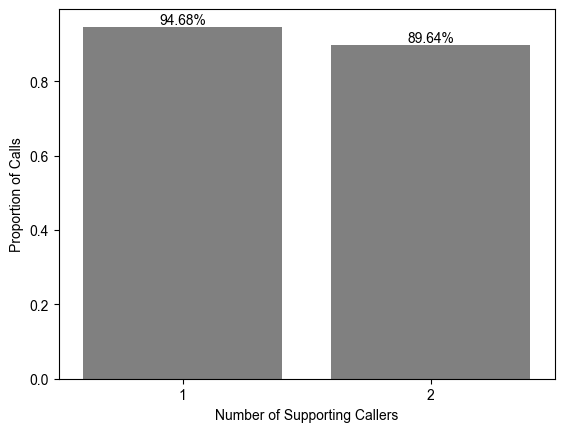

In [115]:
plot_incremental_hist(df_no_inv, include_vapor=include_vapor, distinct_vapor_no_call=distinct_vapor_no_call, color="gray")

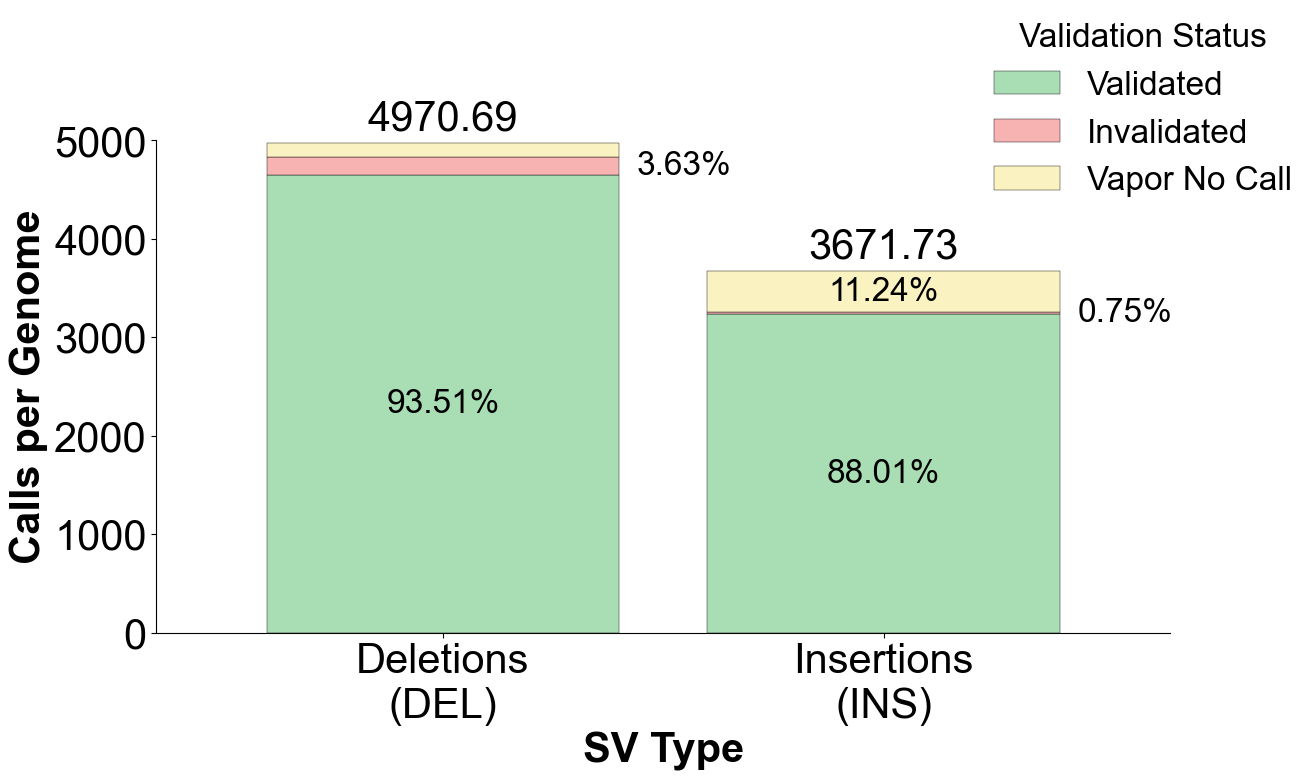

In [140]:
plot_averaged_hist(df_no_inv, group_col="SVTYPE", n_samples=n_samples, support_col="SUPPORT", group_order=["DEL", "INS"],
                   distinct_vapor_no_call=distinct_vapor_no_call, color_map=support_color_map, save_path=os.path.join(out_dir, "SVTYPE_averaged_hist.png"),
                   xlabel='SV Type', xticklabels=['Deletions\n(DEL)', 'Insertions\n(INS)'],
                   legend_title='Validation Status', legend_labels=['Validated', 'Invalidated', 'Vapor No Call'],
                   legend_loc='upper right', legend_bbox_to_anchor=(1.15, 1.3), legend_frameon=False,
                   xlabel_fontsize=30, ylabel_fontsize=30,
                   tick_fontsize=30, total_fontsize=30, percent_fontsize=24,
                   legend_title_fontsize=24, legend_fontsize=24,
                   ylim=(0, 5000), figsize=(12, 7), width=0.8, xtick_rotation=0)

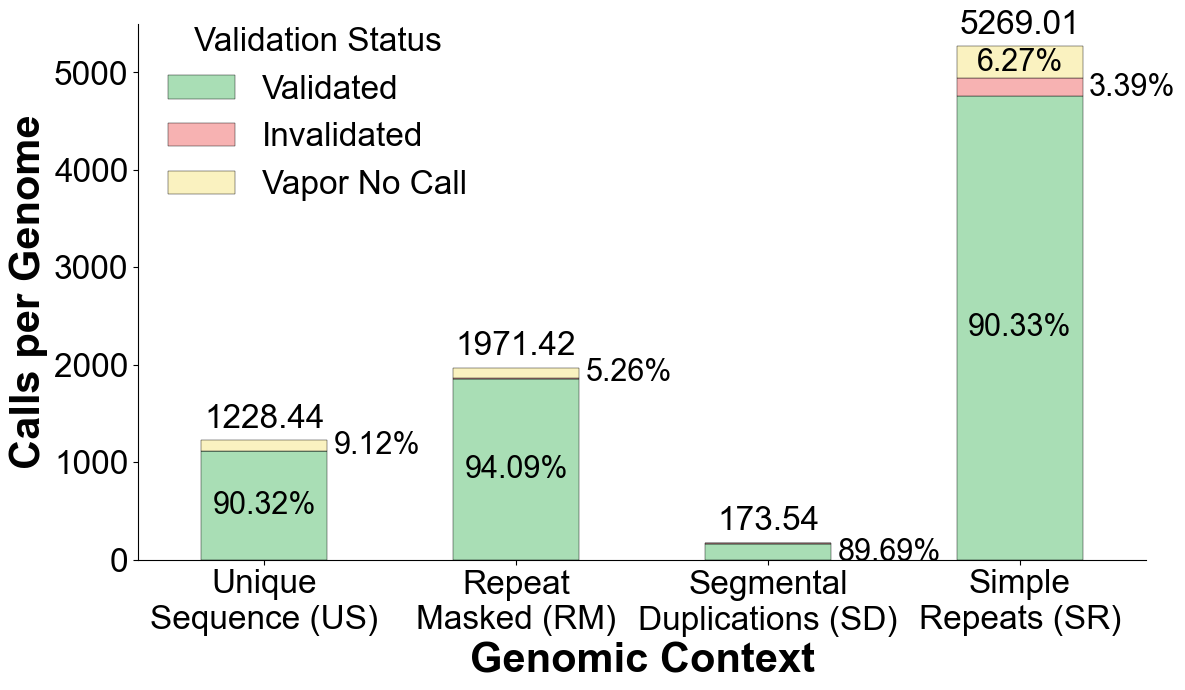

In [151]:
plot_averaged_hist(df_no_inv, group_col="STRAT", n_samples=n_samples, support_col="SUPPORT", group_order=["Unique", "RM", "SD", "SR"],
                   distinct_vapor_no_call=distinct_vapor_no_call, color_map=support_color_map, save_path=os.path.join(out_dir, "STRAT_averaged_hist.png"),
                   xlabel='Genomic Context', xticklabels=['Unique\nSequence (US)', 'Repeat\nMasked (RM)', 'Segmental\nDuplications (SD)', 'Simple\nRepeats (SR)'],
                   legend_title='Validation Status', legend_labels=['Validated', 'Invalidated', 'Vapor No Call'],
                   legend_loc='upper left', legend_bbox_to_anchor=(0, 1.05), legend_frameon=False,
                   xlabel_fontsize=30, ylabel_fontsize=30,
                   tick_fontsize=24, total_fontsize=24, percent_fontsize=22,
                   legend_title_fontsize=24, legend_fontsize=24,
                   ylim=(0, 5500), figsize=(12, 7), width=0.5, xtick_rotation=0)

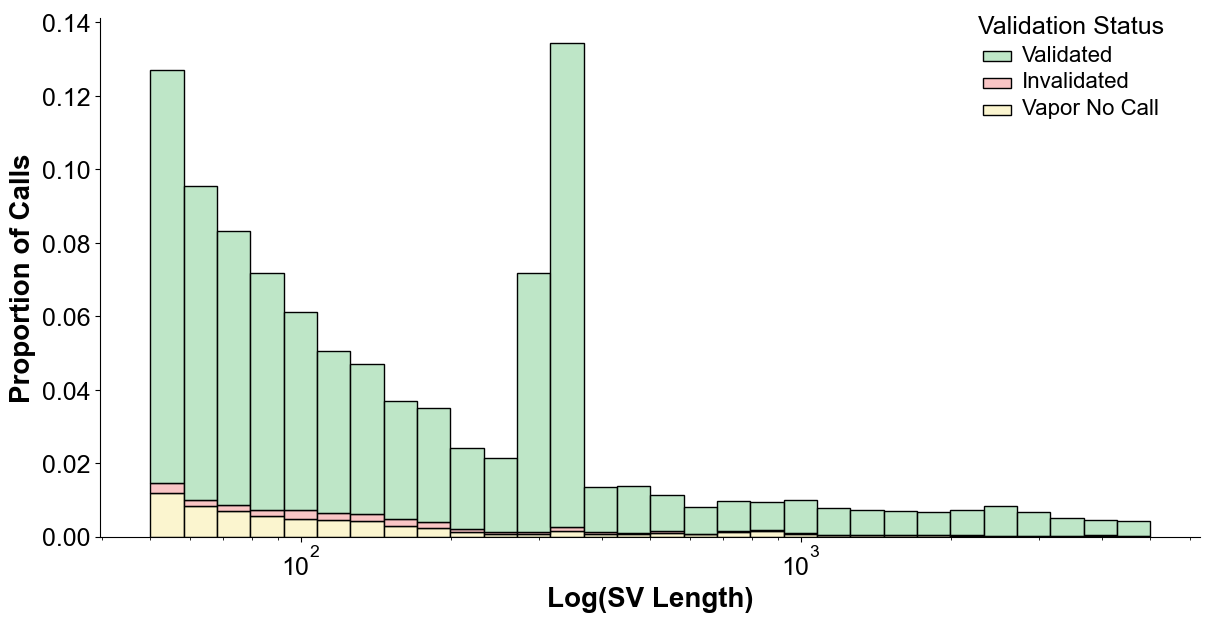

In [118]:
plot_hist(df_no_inv, "SVLEN", hue="SUPPORT", stat="proportion", distinct_vapor_no_call=distinct_vapor_no_call, 
          color_map=support_color_map, save_path=os.path.join(out_dir, "SVLEN_hist.png"),
          legend_title='Validation Status', legend_labels=['Validated', 'Invalidated', 'Vapor No Call'],
          legend_loc='upper right', legend_bbox_to_anchor=(0.85, 1), legend_frameon=False,
          xlabel="Log(SV Length)", ylabel='Proportion of Calls', 
          xlabel_fontsize=20, ylabel_fontsize=20, tick_fontsize=18, 
          legend_title_fontsize=18, legend_fontsize=16,
          bins=30,height=6, aspect=2, log_scale=(True, False))

In [119]:
# plot_hist(df_no_inv, "SIZE", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", log_scale=(True, False), bins=30)

In [120]:
if "GQ" in df.columns:
    plot_hist(df_no_inv, "GQ", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", bins=30)

In [121]:
if "SL" in df.columns:
    plot_hist(df_no_inv, "GQ", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", bins=30)

In [122]:
if "FILTER" in df.columns:
    plot_hist(df_no_inv[df_no_inv["FILTER"] != ""], "FILTER", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion")

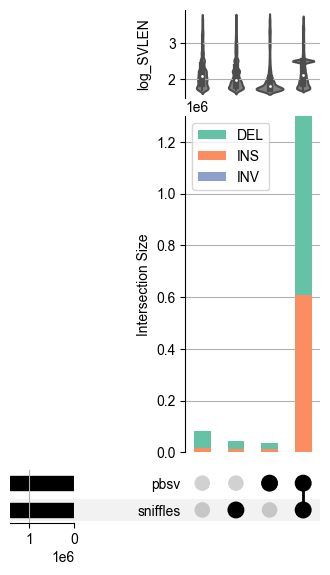

<Figure size 640x480 with 0 Axes>

In [123]:
plot_upset_lr(df_no_inv, ylim=(0, 1300000))

### Inversions

In [124]:
display(HTML("<style>.container { width:100% !important; }</style>"))

df_inv = df[(df['SVTYPE'] == 'INV') & (df['SAMPLE'].isin(inv_samples))]

total_count = df_inv.shape[0]
print(f"Total Calls: {total_count}")

total_sites = df_inv['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df_inv['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

# N_LR_SUPPORT
table_rows = []
for i in range(df_inv["N_LR_SUPPORT"].min(), len(lr_callers) + 1):
    table_rows.append(compute_summary(df_inv, "SRWGS", i, n_samples, support_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# STRAT
if "STRAT" in df.columns:    
    table_rows = []
    for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
        table_rows.append(compute_summary(df, "STRAT", strat, n_samples, pre_filter=True))
    print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# LR Caller
table_rows = []
for caller in lr_callers:
    table_rows.append(compute_summary(df_inv, f"STATUS_{caller}", caller, n_samples, check_binary=True))
print(tabulate(table_rows, headers=["Caller"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVLEN
svlen_bins = {
    "SVLEN < 500": df_inv[df_inv["SVLEN"] < 500],
    "SVLEN 500-1000": df_inv[(df_inv["SVLEN"] >= 500) & (df_inv["SVLEN"] <= 1000)],
    "SVLEN > 1000": df_inv[df_inv["SVLEN"] > 1000]
}
# svlen_bins = {
#     "SVLEN 5-10KB": df_inv[df_inv["SVLEN"] < 10000],
#     "SVLEN 10-50KB": df_inv[(df_inv["SVLEN"] >= 10000) & (df_inv["SVLEN"] <= 50000)],
#     "SVLEN > 50KB": df_inv[df_inv["SVLEN"] > 50000]
# }
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

non_vapor = [c for c in lr_callers if c != "VAPOR"]
sums_nv = df_inv[[f"STATUS_{x}" for x in non_vapor]].sum(axis=1)
sup_nv = (sums_nv >= 1).sum()
prop_nv = sup_nv / total_count * 100

print(f"Calls with support from non-Vapor long-read callers: {sup_nv}")
print(f"Proportion of calls with support from non-Vapor long-read callers: {prop_nv:.2f}%")

Total Calls: 3051
Total Unique Sites: 3049
Total Unique Samples: 21

╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     145.29     │          145.29          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     145.29     │          27.48           │       18.91%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   2    │     145.29     │          15.19           │       10.46%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

╒═════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  STRAT  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞═════════╪════════════════╪══════════════════════════╪═════════════════════╡
│  

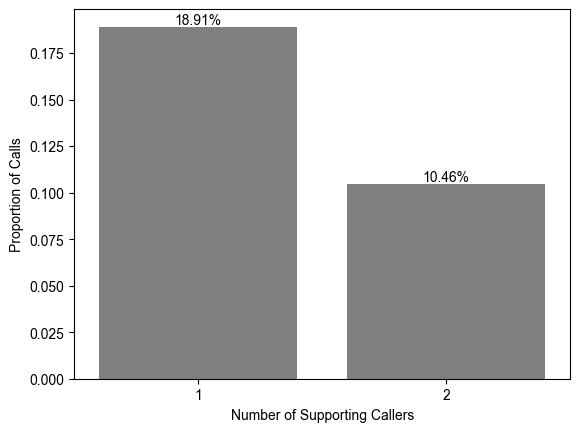

In [125]:
plot_incremental_hist(df_inv, include_vapor=include_vapor, color="gray")

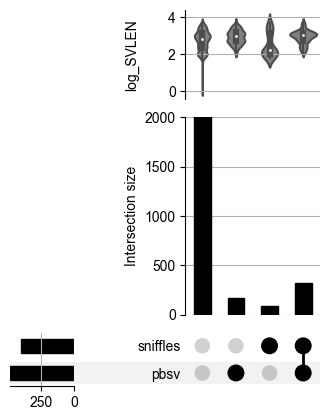

<Figure size 640x480 with 0 Axes>

In [126]:
plot_upset_lr(df_inv, by_svtype=False, ylim=(0, 2000))